In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.special import logsumexp 

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'scipy'

In [15]:
# Ensure reproducibility
random.seed(11)
np.random.seed(11)

In [16]:
####################################################################################################
# watermaze module
####################################################################################################
class watermaze(object):
    
    """
    This class defines a set of functions for simulating a rat moving in a water-maze.
    
    For the purposes of this assignment, you should be using the move function to 
    determine the next state of the environment at each time-step of the simulation.
    
    See the demo of its usage after the module code.
    """
    
    ####################################################################
    # the initialization function, measurements are in cm
    def __init__(self, pool_radius=60, platform_radius=10, platform_location=np.array([25,25]), 
                 stepsize=5.0, momentum=0.2, T=60):
        
        """
        The init function for the watermaze module.
        
        - The pool_radius argument specifies the radius of the pool.
        
        - The platform_radius argument specifies the radius of the platform.
        
        - The platform_location argument specifies the location of the platform centre.
        
        - The stepsize argument specifies how far the rat moves in one step.
        
        - The momentum argument specifies the ratio of old movement to new movement direction (i.e. 
        momentum = 0 means all new movement, momentum = 1 means all old movement, otherwise a mix.
        
        - The T argument is the maximum time for a trial in the pool.

        
        """
        
        # store the given info
        self.radius            = pool_radius
        self.platform_radius   = platform_radius
        self.platform_location = platform_location
        self.stepsize          = stepsize
        self.momentum          = momentum
        self.T                 = T
        
        # a dictionary for calculating directions
        self.direction = {
            0:  np.pi/2, #north
            1:  np.pi/4, #north-east
            2:  0, #east
            3:  7*np.pi/4, #south-east
            4:  3*np.pi/2, #south
            5:  5*np.pi/4, #south-west
            6:  np.pi, #west
            7:  3*np.pi/4, #north-west
        }
        
        # initialize the dynamic variables
        self.position = np.zeros((2,T))
        self.t        = 0
        self.prevdir  = np.zeros((2,))
        
    ####################################################################
    # for updating the rat's position in the pool
    def move(self, A):

        """
        Updates the simulated rat's position in the water-maze environment by moving it in the 
        specified direction. 
        
        - The argument A is the last selected action, and must be an integer from 0-7, with 0 indicating N, 
        1 indicating NE, etc. 

        """
        
        # check the A argument
        if (not np.isin(A, np.arange(8))):
            print('Error: The argument A must be an integer from 0-7, indicating which action was selected.')

        # determine the vector of direction of movement
        angle = self.direction[A]
        newdirection = np.array([np.cos(angle), np.sin(angle)])
        
        # add in momentum to reflect actual swimming dynamics (and normalize, then multiply by stepsize)
        direction = (1.0 - self.momentum)*newdirection + self.momentum*self.prevdir
        direction = direction/np.sqrt((direction**2).sum())
        direction = direction*self.stepsize
        
        # update the position, prevent the rat from actually leaving the water-maze by having it "bounce" off the wall 
        [newposition, direction] = self.poolreflect(self.position[:,self.t] + direction)

        # if we're now at the very edge of the pool, move us in a little-bit
        if (np.linalg.norm(newposition) == self.radius):
            newposition = np.multiply(np.divide(newposition,np.linalg.norm(newposition)),(self.radius - 1))

        # update the position, time (and previous direction)
        self.position[:,self.t+1] = newposition
        self.t                    = self.t + 1
        self.prevdir              = direction
        
        return newposition
    ####################################################################
    # for bouncing the rat off the wall of the pool
    def poolreflect(self, newposition):
        
        """
        The poolreflect function returns the point in space at which the rat will be located if it 
        tries to move from the current position to newposition but bumps off the wall of the pool. 
        If the rat would not bump into the wall, then it simply returns newposition. The function 
        also returns the direction the rat will be headed.
        """

        # determine if the newposition is outside the pool, if not, just return the new position
        if (np.linalg.norm(newposition) < self.radius):
            refposition  = newposition
            refdirection = newposition - self.position[:,self.t]

        else:

            # determine where the rat will hit the pool wall
            px = self.intercept(newposition)
            
            # get the tangent vector to this point by rotating -pi/2
            tx = np.asarray(np.matmul([[0, 1], [-1, 0]],px))

            # get the vector of the direction of movement
            dx = px - self.position[:,self.t]
            
            # get the angle between the direction of movement and the tangent vector
            theta = np.arccos(np.matmul((np.divide(tx,np.linalg.norm(tx))).transpose(),(np.divide(dx,np.linalg.norm(dx))))).item()

            # rotate the remaining direction of movement vector by 2*(pi - theta) to get the reflected direction
            ra = 2*(np.pi - theta)
            refdirection = np.asarray(np.matmul([[np.cos(ra), -np.sin(ra)], [np.sin(ra), np.cos(ra)]],(newposition - px)))

            # get the reflected position
            refposition = px + refdirection

        # make sure the new position is inside the pool
        if (np.linalg.norm(refposition) > self.radius):
            refposition = np.multiply((refposition/np.linalg.norm(refposition)),(self.radius - 1))

        return [refposition, refdirection]
    
    ####################################################################
    # for checking when/where the rat hits the edge of the pool
    def intercept(self,newposition):
        
        """
        The intercept function returns the point in space at which the rat will intercept with the pool wall 
        if it is moving from point P1 to point P2 in space, given the pool radius.
        """
        
        # for easy referencing, set p1 and p2
        p1 = self.position[:,self.t]
        p2 = newposition

        # calculate the terms used to find the point of intersection
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        dr = np.sqrt(np.power(dx,2) + np.power(dy,2))
        D  = p1[0]*p2[1] - p2[0]*p1[1]
        sy = np.sign(dy)
        if (sy == 0):
            sy = 1.0
            
        # calculate the potential points of intersection
        pp1 = np.zeros((2,))
        pp2 = np.zeros((2,))

        pp1[0] = (D*dy + sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[0] = (D*dy - sy*dx*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp1[1] = (-D*dx + np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))
        pp2[1] = (-D*dx - np.absolute(dy)*np.sqrt((np.power(self.radius,2))*(np.power(dr,2))-np.power(D,2)))/(np.power(dr,2))

        # determine which intersection point is actually the right one (whichever is closer to p2)
        if np.linalg.norm(p2 - pp1) < np.linalg.norm(p2 - pp2):
            px = pp1

        else:
            px = pp2
        
        return px
    
    ####################################################################
    # sets the start position of the rat in the pool
    def startposition(self, start_p=None, flag=True):

        if flag:
            # select a random location from the main cardinal axes and calculate it's vector angle
            condition = 2*np.random.randint(0,4)
            angle = self.direction[condition]

            self.position[:,0] = np.asarray([np.cos(angle), np.sin(angle)]) * (self.radius - 1)
            start_p = self.position[:,0]
        else:
            self.position[:,0] = start_p
        
        return start_p
    ####################################################################
    # plot the most recent path of the rat through the pool
    def plotpath(self):
        
        # create the figure 
        fig = plt.figure()
        ax = fig.gca()

        # create the pool perimeter
        pool_perimeter = plt.Circle((0, 0), self.radius, fill=False, color='b', ls='-')
        ax.add_artist(pool_perimeter)

        # create theplatform
        platform = plt.Circle(self.platform_location, self.platform_radius, fill=False, color='r', ls='-')
        ax.add_artist(platform)

        # plot the path
        plt.plot(self.position[0,0:self.t],self.position[1,0:self.t], color='k', ls='-')

        # plot the final location and starting location
        plt.plot(self.position[0,0],self.position[1,0],color='b', marker='o',markersize=4, markerfacecolor='b')
        plt.plot(self.position[0,self.t-1],self.position[1,self.t-1],color='r', marker='o',markersize=6, markerfacecolor='r')

        # adjust the axis
        ax.axis('equal')
        ax.set_xlim((-self.radius-50, self.radius+50))
        ax.set_ylim((-self.radius-50, self.radius+50))
        plt.xticks(np.arange(-self.radius, self.radius+20, step=20))
        plt.yticks(np.arange(-self.radius, self.radius+20, step=20))
        ax.set_xlabel('X Position (cm)')
        ax.set_ylabel('Y Position (cm)')

        # turn on the grid
        plt.grid(True)
        plt.tight_layout()

        # show the figure
        plt.show()
        
    ####################################################################
    # checks whether the time is up
    def timeup(self):
        
        """
        Returns true if the time for the trial is finished, false otherwise.
        """
        
        return self.t > (self.T - 2)
    
    ####################################################################
    # checks whether the rat has found the platform
    def atgoal(self):
        
        """
        Returns true if the rat is on the platform, false otherwise.
        """
        
        return np.sqrt(np.sum((self.position[:,self.t] - self.platform_location)**2)) <= (self.platform_radius + 1)

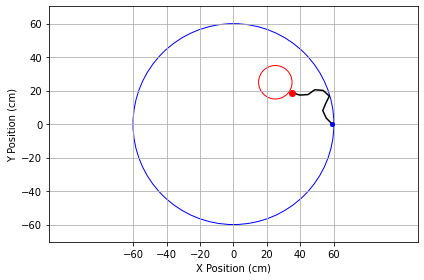

Clever rat, you found the platform in 10 seconds!


In [17]:
# demo of how to use the watermaze module

# create the watermaze object
maze = watermaze()

# set the starting location
maze.startposition()

# run forward for one trial (using random actions for sake of illustration)
while(not maze.timeup() and not maze.atgoal()):
    
    # select a random action - this is what your actor critic network needs to provide
    A = np.random.randint(0,8)
    
    # move the rat
    maze.move(A)
    
# plot the path
maze.plotpath()

# print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
if maze.atgoal():
    print("Clever rat, you found the platform in",maze.t,"seconds!")
else:
    print("No more time for you dumb-dumb...")

In [18]:
"""
Generate even distribution of n place field center coordinates on the maze surface using 
the sunflower distribution taken from: 

https://stackoverflow.com/questions/28567166/uniformly-distribute-x-points-inside-a-circle
"""
#Generates n coordinates for the place field centers
def sunflower_dist(pool_radius,n):
    phi = (math.sqrt(5)+1)/2
    
    s_i = np.zeros((n, 2)) #place field centers
    
    for k in range(1, n+1):
        r = radius(pool_radius, k, n)
        theta = 2*math.pi*k/phi**2
        s_i[k-1] = r*math.cos(theta), r*math.sin(theta) 
    
    return s_i

#Returns the radius used to find place field centers ...
def radius(pool_radius, k, n):
    r = pool_radius*(math.sqrt(k-1/2)/math.sqrt(n-1/2))
    return r

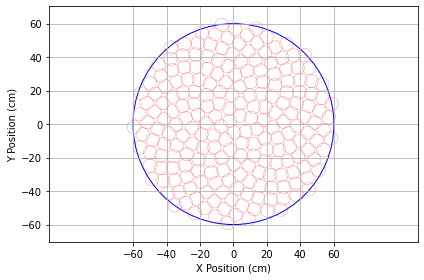

In [19]:
# Plot pool
fig = plt.figure()
ax = plt.gca()
pool_radius = 60
pool_perimeter = plt.Circle((0, 0), pool_radius, fill=False, color='b', ls='-')
ax.add_artist(pool_perimeter)

# Plot place fields
s_i = sunflower_dist(pool_radius,220)
for x,y in s_i:
    place_field = plt.Circle((x,y), 4, fill=False, color='r', ls='-', lw=0.2)
    ax.add_artist(place_field)

# Adjust axes
ax.axis('equal')
ax.set_xlim((-pool_radius-50, pool_radius+50))
ax.set_ylim((-pool_radius-50, pool_radius+50))
plt.xticks(np.arange(-pool_radius, pool_radius+20, step=20))
plt.yticks(np.arange(-pool_radius, pool_radius+20, step=20))
ax.set_xlabel('X Position (cm)')
ax.set_ylabel('Y Position (cm)')

# Turn on grid
plt.grid(True)
plt.tight_layout()
plt.show()

## Reward Based Actor-Critic Model

In [20]:
'''
The actor-critic network using the pure TD-algorithm
'''
class pure_TD(object):
    
    def __init__(self, n=473, sigma=9.6, l=0.9, lr_a=0.1, lr_c= 0.03, circle_radius=60):
        
        self.n = n         #Number of place field cells
        self.sigma = sigma #As defined in the paper, scaled to the size of our pool
        self.Lambda = l    #As defined in the paper, makes learning faster
        self.lr_a = lr_a   #Actor learning rate as defined in the paper
        self.lr_c = lr_c   #Critic learning rate as defined in the paper
        
        self.S = sunflower_dist(circle_radius, n) #Place field centers
        self.place_fields = np.zeros(n)           #Place field activations
        self.W = np.zeros(n)                      #Place field weights 
        self.C = 0                                #Critic cell activation
        self.Z = np.zeros((8, n))                 #Action cell weights 
        self.A = np.zeros(8)                      #Action cell activations 
        
        self.p = np.zeros(2) #Current position
        self.R = 0           #Current reward
        
    def initialize(self, start_p):
        '''
        Function used to initialize start position, activations and set reward to 0
        '''
        self.p = start_p
        self.place_fields = self.place_activation(self.p)
        self.C = self.critic_activation()
        self.A = self.action_activation()
        self.R = 0
        
    def place_activation(self, position):
        '''
        Equation 1: Gaussian function of location
        '''
        
        distances = np.linalg.norm(position - self.S, axis=1)
        
        return np.exp(-(distances/(2*self.sigma**2)))
    
    def critic_activation(self):
        '''
        Equation 2: Weighted sum of firing rates of place cell inputs to critic unit
        '''
        
        return np.dot(self.W, self.place_fields)
    
    def action_activation(self):
        '''
        Equation (unlabelled): Weighted sum of firing rates of place cell inputs to actor units
        '''
    
        return np.dot(self.place_fields, self.Z.T)
    
    def action_probability(self):
        '''
        Equation 9: Relative preference for swimming in the jth direction at location p
        '''
        p = [(2*self.A[k] - logsumexp(2*self.A)) for k in range(8)]
        return np.exp(p)
                     
    def action(self):
        '''
        This function uses the probabilities computed using equation 9 to choose an action stochastically
        '''
        
        return  np.random.choice(8, p=self.action_probability())  

    def move(self, new_position, reward):
        '''
        This function moves the mouse to the next location corresponding to time at t+1 and computes the 
        new activations for the network. Returns the critic and place fields' activations at time t.
        '''
        C_t = self.C       
        place_fields_t = self.place_fields
        
        self.p = new_position
        self.place_fields = self.place_activation(self.p)
        self.C = self.critic_activation()
        self.A = self.action_activation()
        self.R = reward
        
        return C_t, place_fields_t
        

    def update(self, C_t, place_fields_t, action):
        '''
        Equations 7, 8 and 10. This function updates the weights of the network using TD learning.
        '''
        if self.R == 0:
            
            delta = self.Lambda*self.C - C_t
            self.W += self.lr_c*delta*place_fields_t
            self.Z[action,:] += self.lr_a*delta*place_fields_t
        
        else:
            delta = 1 - C_t
            self.W += self.lr_c*delta*place_fields_t

In [21]:
def trial_pure_TD(maze, mouse):
    # run forward for one trial using actions provided by the mouse hippocampal model
    while(not maze.timeup() and not maze.atgoal()):

        # Select action
        A = mouse.action()

        # Get new position in the maze
        newposition = maze.move(A)

        #Move the rat
        c_t, place_fields_t = mouse.move(newposition, maze.atgoal())

        #Update weights
        mouse.update(c_t, place_fields_t, A)
    
    return maze.t

### Pure TD learning model demo

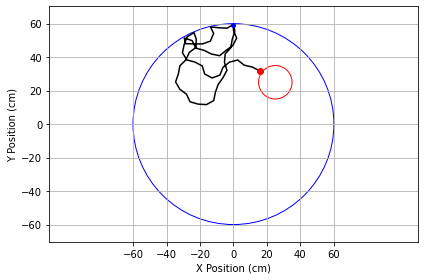

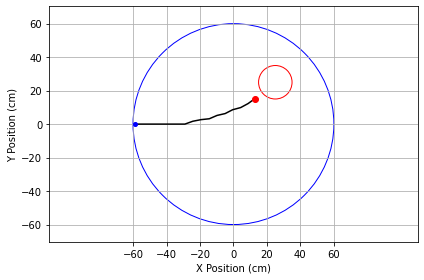

Accuracy: 0.9785714285714285


In [22]:
#Create the pure TD hippocampal place cell model
mouse = pure_TD(n=230, sigma=4)

succ = 0
for i in range(280):
    maze = watermaze()
    start_p = maze.startposition()
    mouse.initialize(start_p)
    trial_pure_TD(maze, mouse)
    
    # plot the 1st path, 1st successful path and last path
    if i == 0:
        maze.plotpath()
    elif succ == 0 and maze.atgoal():
        maze.plotpath()
    elif i == 279:
        maze.plotpath()
    
    # print out why the trial ended (note, if the rat reached the goal, then you must deliver a reward)
    if maze.atgoal():
        #print("Clever rat, you found the platform in",maze.t,"seconds!")
        succ += 1 
    #else:
        #print("No more time for you dumb-dumb...")
print('Accuracy: {}'.format(succ/280))

## Coordinate-Based Actor-Critic Model

In [63]:
'''
The actor-critic network using the combined coordinate and TD-algorithm. 
'''

class coordinate_based(object):
    
    def __init__(self, n=177, sigma=9.6, l=0.9, eta_a=0.4, eta_coor=0.01, eta_c=0.03, num_trials=60, circle_radius=60):
        
        self.n = n                                #Number of place field cells
        self.sigma = sigma                        #As defined in the paper, scaled to the size of our pool
        self.Lambda = l                           #As defined in the paper, makes learning faster
        self.eta_a = eta_a                        #Actor learning rate 
        self.eta_coor = eta_coor                  #Coordinate system learning rate
        self.eta_c = eta_c                        #Critic learning rate 
       
        
        self.S = sunflower_dist(circle_radius, n) #Place field centers
        self.place_fields = np.zeros(n)           #Place field activations
        self.W = np.zeros(n)                      #Place field weights 
        self.C = 0                                #Critic cell activation
        self.Z = np.zeros((8, n))                 #Action cell weights 
        self.A = np.zeros(8)                      #Action cell activations
        
        self.X = 0                                #X coordinate activation
        self.Y = 0                                #Y coordinate activation
        self.X_weights = np.zeros(n)              #X-coordinate unit weights
        self.Y_weights = np.zeros(n)              #Y-coordinate unit weights
        self.XY_mem = None                        #Memory of last location of the platform
        self.a_coord = 0                          #Abstract coordinate activation 
        self.abstract_dir = None
        self.trace = np.zeros((num_trials, n))    #Trace: acts as a decaying memory of previous place cell activations
               
        self.p = np.zeros(2)                      #Current position
        self.R = 0                                #Current reward
        self.num_trials = num_trials              #Number of trials
        
        #Direction array to choose action from
        self.direction = np.array([
            np.pi/2,   #north
            np.pi/4,   #north-east
            0,         #east
            7*np.pi/4, #south-east
            3*np.pi/2, #south
            5*np.pi/4, #south-west
            np.pi,     #west
            3*np.pi/4  #north-west
        ])
        
    def initialize(self, start_p):
        '''
        Function used to initialize start position, activations and set reward and trace to 0
        '''
        self.p = start_p
        self.place_fields = self.place_activation(self.p)
        self.C = self.critic_activation()
        self.A = self.action_activation()
        self.X = self.coordinate_system_activation(X=True)
        self.Y = self.coordinate_system_activation(X=False)
        self.R = 0
        self.trace = np.zeros((self.num_trials, self.n))
        
    def place_activation(self, position):
        '''
        Equation 1: Gaussian function of location
        '''
        
        distances = np.linalg.norm(position - self.S, axis=1)
        
        return np.exp(-distances/(2*self.sigma**2))
    
    def critic_activation(self):
        '''
        Equation 2: Weighted sum of firing rates of place cell inputs to critic unit
        '''
        
        return np.dot(self.W, self.place_fields)
    
    def action_activation(self):
        '''
        Equation (unlabelled, page 5): Weighted sum of firing rates of place cell inputs to actor units
        '''
    
        return np.dot(self.place_fields, self.Z.T)
    
    def coordinate_system_activation(self, X=True):
        '''
        Equation (unlabelled, page 8): This function returns the weights between the place field cells 
        and the coordinate system
        '''
        
        if X:
            return np.nan_to_num(np.dot(np.nan_to_num(self.X_weights), self.place_fields))
        else:
            return np.nan_to_num(np.dot(np.nan_to_num(self.Y_weights), self.place_fields))
       
    def action_probability(self, actions):
        '''
        Equation 9: Relative preference for swimming in the jth direction at location p
        '''
        p = [(2*actions[k] - logsumexp(2*actions)) for k in range(len(actions))]

        return np.exp(p)
                     
    def action(self):
        '''
        This function uses the probabilities computed using equation 9 to choose an action stochastically
        '''
        
        #Only consider abstract action if a previous platform coordinate has been stored
        if self.XY_mem is not None:          
            action = np.random.choice(9, p=self.action_probability(np.append(self.A, self.a_coord)))
        else: 
            action = np.random.choice(8, p=self.action_probability(self.A))
       
        return action

    def move(self, new_position, reward):
        '''
        This function moves the mouse to the next location corresponding to time at t+1 and sets the 
        new activations for the network. Returns the critic and place fields' activations at time t as 
        well as the X and Y coordinates of the coordinate system at time t.
        '''
        
        #Save relevant values for update from time t
        C_t = self.C       
        place_fields_t = self.place_fields
        X_t = self.X
        Y_t = self.Y
        
        #Update model with respect to new position
        self.p = new_position
        self.place_fields = self.place_activation(self.p)
        self.C = self.critic_activation()
        self.A = self.action_activation()
        self.X = self.coordinate_system_activation(X=True)
        self.Y = self.coordinate_system_activation(X=False)
        self.R = reward
        
        return C_t, place_fields_t, X_t, Y_t
        
    def compute_direction(self):
        '''
        This function computes the direction to which the abstract action corresponds and returns 
        an integer between 0 and 7 by choosing the closest angle to one of the 8 possible discrete actions
        '''
        diff = self.XY_mem - np.array([self.X, self.Y])
        angle = math.atan2(diff[0], diff[1])
        
        if angle < 0:
            angle += 2*math.pi
        
        return np.abs(self.direction - angle).argmin()  
       
    def update_model(self, C_t, place_fields_t, X_t, Y_t, action, self_motion, t):
        '''
        Equations 7, 8 and 10, 11, 12. This function updates the weights of the network using TD learning
        and the parameters of the coordinate system
        '''
        #Updates for actor-critic networks
        if self.R == 0:
            delta = self.Lambda*self.C - C_t   
            if action < 8:
                self.Z[action,:] += self.eta_a*delta*place_fields_t
        else:
            delta = 1 - C_t
       
        if action == 8:
            self.a_coord += delta
        
        self.W += self.eta_c*delta*place_fields_t
        
        # Store the last firing sequence of the place cells
        self.trace[t-1,:] = place_fields_t
        
        
        #Update weights of the coordinate system (Equation 11 and 12)
        trace = self.eligibility_trace(t)
        self.X_weights += self.eta_coor*(5*math.cos(self_motion) + X_t - self.X)*trace
        self.Y_weights += self.eta_coor*(5*math.sin(self_motion) + Y_t - self.Y)*trace
        
        #Verify whether new destination is same as stored coordinate or if goal has been reached
        if np.array_equal(self.XY_mem, [self.X, self.Y]) and self.R == 0:
            self.XY_mem = None
        elif self.XY_mem is None and self.R == 1:
            self.XY_mem = np.array([self.X, self.Y])
    
    def eligibility_trace(self, t):
        '''
        This function computes the eligibility trace used to update the coordinate system weights 
        Returns the sums on the right of Equations 11 and 12
        '''
        #This array contains decaying values of lambda
        lambda_decay = np.nan_to_num(np.flip([self.Lambda**(t - k+1) for k in range(t)]))
        
        return np.sum((self.trace[0:t,:].T*lambda_decay).T, axis=0)
    
    def get_self_motion(self, action):
        '''
        This function returns the direction of movement associated with the input action in radians
        '''
            
        return self.direction[action]

In [46]:
def trial_coordinate_based(maze, mouse):
    while(not maze.timeup() and not maze.atgoal()):

        # Select action
        A = mouse.action()
        
        #Determine if abstract action or regular action
        if A == 8:
            action_index = mouse.compute_direction()
        else:
            action_index = A
            
        # Get new position in the maze
        newposition = maze.move(action_index)

        #Move the rat
        c_t, place_fields_t, X_t, Y_t  = mouse.move(newposition, maze.atgoal())

        #Update model
        mouse.update_model(c_t, place_fields_t, X_t, Y_t, A, mouse.get_self_motion(action_index), maze.t)
        
    return maze.t

### Coordinate-Based Actor-Critic Model Demo

First path


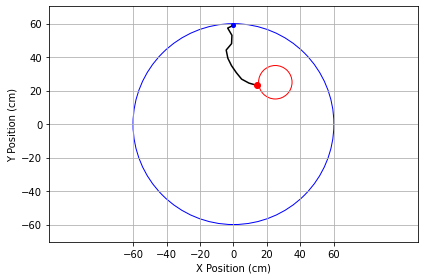

AttributeError: 'NoneType' object has no attribute 'savefig'

In [97]:
#Create the coordinate-based TD hippocampal model
mouse = coordinate_based(n=230, sigma=4, eta_a=0.2, eta_coor=0.01, eta_c=0.03)

succ = 0
for i in range(280):
    maze = watermaze()
    start_p = maze.startposition()
    mouse.initialize(start_p)
    trial_coordinate_based(maze, mouse)
    
    # plot the 1st path, 1st successful path and last path
    if i == 0:
        print('First path')
        maze.plotpath()

    elif succ == 0 and maze.atgoal():
        print('First successful path')
        maze.plotpath()      
    elif i == 279:
        print('Last path')
        maze.plotpath()

    if maze.atgoal():
        succ += 1 
print('Accuracy: {}%'.format((succ/280)*100))

## Testing and Plotting Functions

In [100]:
def test(simulations=500, multi_platform=False, platform_locations=None, pure_td=True):
    
    history = np.zeros((simulations, 28))  
    succ = 0
    for simulation in range(simulations):
       
        if pure_td:
            mouse = pure_TD(n=230, sigma=4)
        else: 
            mouse = coordinate_based(n=230, sigma=4, eta_a=0.2, eta_coor=0.01, eta_c=0.03)

        location = 0
        start_p = None
        for trial in range(28): 
            if trial%4 == 0 and multi_platform:
                position = platform_locations[location]
                location += 1
            else:
                position = np.array([25,25])
            
            #Repeat trial 10x so that mouse learns
            for repeat in range(10):
                    
                maze = watermaze(platform_location=position)
                if trial%4 == 0 and repeat==0:
                    start_p = maze.startposition()
                mouse.initialize(start_p)

                if pure_td: 
                    time = trial_pure_TD(maze, mouse)
                else:
                    time = trial_coordinate_based(maze, mouse)

                history[simulation, trial] += time

                if maze.atgoal():
                    succ += 1
              
        history[simulation,:] /= 10
    return history, succ/(simulations*28*10)

def plot(history, filename):
    
    mean_time = np.mean(history, axis=0)
    std_error = np.std(history, axis=0)
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.gca()
    ax.set_xlabel('Day', fontsize = 18)
    ax.set_ylabel('Time to platform (s)', fontsize = 18)
    ax.set_ylim((0, 70))
    
    labels = ['','1','','', '', '2', '', '', '', '3', '', '', '',
                                 '4', '', '', '', '5', '', '', '', '6', '', '', '',
                                 '7', '', '']
    intervals = [0.25, 0.50, 0.75, 1, 1.75, 2, 2.25, 2.5, 3.25, 3.50, 3.75, 
                              4, 4.75, 5, 5.25, 5.50, 6.25, 6.50, 6.75, 7.0, 7.75, 8, 8.25,
                              8.5, 9.25, 9.5, 9.75, 10]
    ax.xaxis.set_major_locator(FixedLocator(intervals))
    ax.xaxis.set_major_formatter(FixedFormatter(labels))
    
    
    plt.errorbar(intervals, mean_time, std_error, fmt='_-k', linestyle='-', capsize=3)
        
    fig = plt.gcf()
    plt.savefig(filename)
    plt.show()
    
    
    

# Actor-Critic Model Experiments

## RMW task

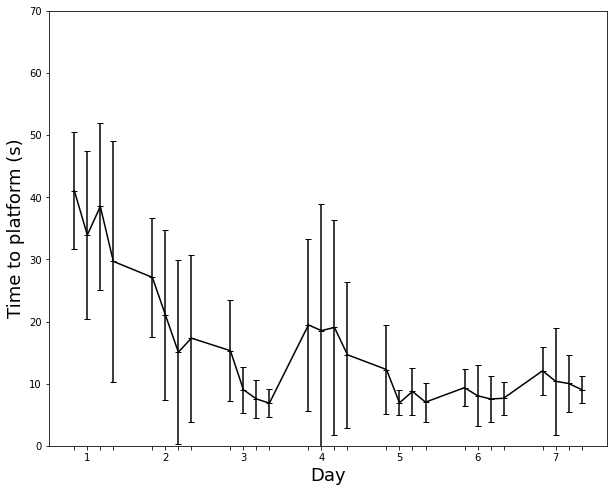

Performance: 0.8935714285714286


In [102]:
history, performance = test(simulations=10)
filename = 'RMW_task_pureTD'
plot(history, filename)
print('Performance: {}'.format(performance))

## DMP task

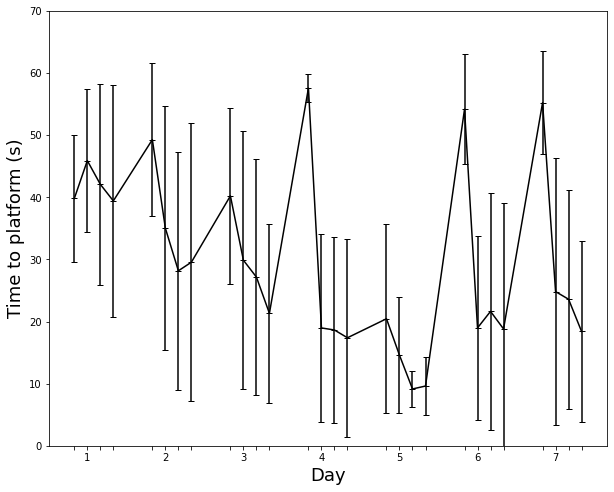

Performance: 0.6407142857142857


In [103]:
platform_locations = np.array([[0,25], [-10,-10], [25,0], [-25, 0], [25,25], [0, -25], [-25, -25]])
history, performance = test(simulations=10, multi_platform=True, platform_locations=platform_locations)
filename = 'DMP_task_pureTD'
plot(history, filename)
print('Performance: {}'.format(performance))

# Coordinate-Based Model Experiments

## RMW task 

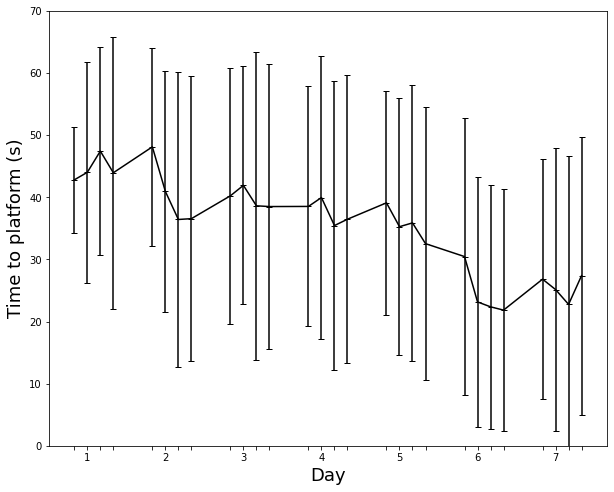

Performance: 0.5175


In [104]:
history, performance = test(simulations=10, pure_td=False)
filename = 'RMW_task_coor'
plot(history, filename)
print('Performance: {}'.format(performance))

## DMP task

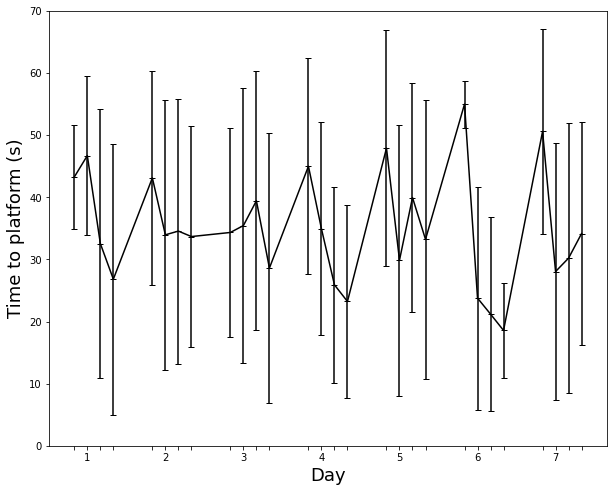

Performance: 0.5414285714285715


In [105]:
platform_locations = np.array([[0,25], [25,0], [25,25], [-10,30], [-25, 0], [0, -25], [-25, -25]])
history, performance = test(simulations=10, multi_platform=True, platform_locations=platform_locations, pure_td=False)
filename = 'DMP_task_coor'
plot(history, filename)
print('Performance: {}'.format(performance))